In [314]:
import ROOT

#import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm

ROI_LOW = 4000
ROI_HIGH = 6800

# ROI for Boron scan
#ROI_LOW  = 2850
#ROI_HIGH = 3700

# For online analysis
runs = [549]
#runs = range(165, 173)

#runsAndEnergies = [[137, 180.0], [164, 250.0], [172, 160.0], [200, 170.0]]

energy = 299.97

# For offline analysis when the logbook is available
#runs = [i for i in range(100, 124)]
#df = pd.read_excel("19F+p_400kV.xlsx", sheet_name="Runs", header=0)


RUN: 549
E: 299.97

Run DAQ time:  76.02803549  seconds
Run TetrAMM time:  90.5  seconds
Charge:  5536.570632919  uC
Counts  5968  +/-  77.25283166331187
Yield  1.0779235732162133  +/-  0.013953191747249958


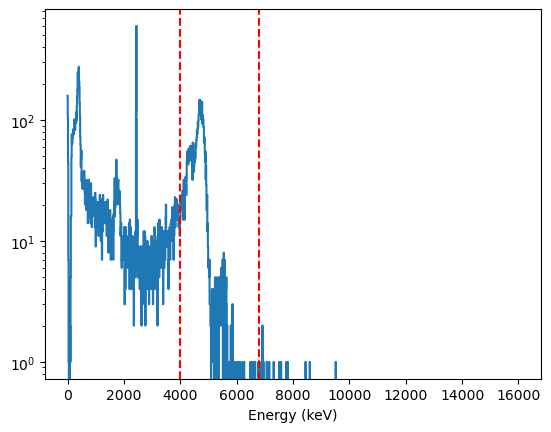

<Figure size 640x480 with 0 Axes>

In [315]:
data = []
for run in runs:
#for run, energy in runsAndEnergies:
    print()
    print("RUN:", run)
    print("E:", energy)
    print()
    
    events = []

    # Find the curent file
    try:
        current = np.loadtxt(f"../data/run{run}/current.txt")
    except:
        print(f"Run {run}: Current file not found")
        continue

    # Find energy of the run
    #energy = df.loc[df["Run Number"] == run, "Energy"].values[0]
    #print(f"Run {run}: {energy} keV")

    # Open the file
    try:
        file = ROOT.TFile(f"../data/root/run{run}.root")
    except:
        print(f"Run {run}: File not found")
        continue

    #current = np.loadtxt(f"data/run{run}.txt")

    # Get the tree
    tree = file.Get("DataR")

    # Get last time stamp
    tree.GetEntry(tree.GetEntries()-1)
    last_time = tree.TimeStamp / 1e8

    last_time_current = current[-1, 0]

    print( "Run DAQ time: ", last_time, " seconds" )
    print( "Run TetrAMM time: ", last_time_current, " seconds" )

    # Charge integrate up to the last time stamp
    charge = 0
    for i in range(1, len(current)):
        if current[i, 0] > last_time:
            break
        dt = current[i, 0] - current[i-1, 0]
        charge += current[i-1, 1] * dt

    print( "Charge: ", charge, " uC" )

    # Count how many events in the ROI with TTree utilities
    events = tree.Draw("Energy", f"Energy > {ROI_LOW} && Energy < {ROI_HIGH} && Channel == 1", "goff")
   
    print( "Counts ", events, r" +/- ", np.sqrt(events) )
    print( "Yield ", events / charge, r" +/- ", np.sqrt(events) / charge )

    # Draw the histogram
    hist = ROOT.TH1D("hist", "hist", 1600, 0, 16000)
    tree.Draw("Energy >> hist", f"Channel == 1", "goff")

    # Convert to numpy histogram
    x = hist.GetXaxis()
    bins = np.array([hist.GetBinContent(i) for i in range(1, hist.GetNbinsX()+1)])
    
    # Plot the histogram
    plt.step(np.linspace(0, 16000, 1600), bins, where="mid")
    plt.yscale("log")
    plt.xlabel("Energy (keV)")

    plt.axvline(ROI_LOW, color="red", linestyle="--")
    plt.axvline(ROI_HIGH, color="red", linestyle="--")

    # Save the histogram
    plt.show( )

    plt.cla( )
    plt.clf( )

    y = events / charge
    yerr = np.sqrt(events) / charge

    data.append([run, energy, charge, events, y, yerr])

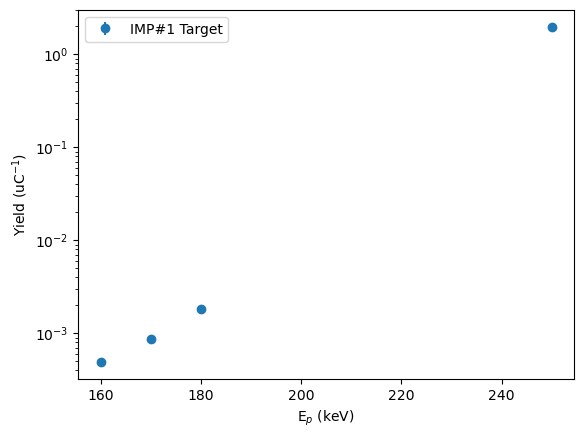

In [9]:
# Plot the scan

if True:
    data = np.array(data)

    plt.errorbar(data[:, 1], data[:, 4], yerr=data[:, 5], fmt="o", label="IMP#1 Target")

    #plt.title(r"$^{19}$F + p - Scan of the 230 keV Resonance")

    plt.xlabel(r"E$_{p}$ (keV)")
    plt.ylabel(r"Yield (uC$^{-1}$)")

    plt.yscale("log")

    plt.legend()

    plt.show()